In [1]:
# ML_in_Finance_Market_Impact
# Author: Matthew Dixon and Igor Halperin
# Version: 1.0 (14.10.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and I. Halperin, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

# Market Impact Problem

Assume that the broker has to sell $ N $ blocks of shares with $ n $ shares in each block, e.g. we can have N = 10, n = 1000.
The state of the inventory at time $ t $ is then given by the variable $ X_t $ taking values in a set $ \mathcal{X} $ with $ N = 10 $ states $ X^{(n)} $, so that the start point at $ t = 0 $ is $ X_0 = X^{(N-1)} $ and the target state is $ X_T = X^{(0)} = 0$. In each step, the agent has four possible actions $ a_t = a^{(i)} $ that measure the number of blocks of shares sold at time $ t $ where $ a^{(0)} = 0 $
stands for no action, and $ a^{(i)} = i $
with $ i = 1, \ldots, 3$ is the number of blocks sold. The update equation is 
$$
X_{t+1} = \left(X_{t} - a_t \right)_{+}
$$
Trades influence the stock price dynamics through a linear market impact
$$
S_{t+1} = S_{t} e^{\left( 1 - \nu a_t \right)}
+ \sigma S_t Z_t 
$$
where $\nu$ is a market friction parameter. To map onto a finite MDP problem, a range of possible stock prices $ \mathcal{S} $ can be discretized to $ M $ values, e.g. $ M = 12 $.
The state space of the problem is given by a direct product of states $ \mathcal{X} 
\times \mathcal{S} $ of dimension $ N \times M = 10 \cdot 12 = 120 $. The dimension of the extended space including the time is then $ 120 \cdot 10 = 1200 $.

The payoff of selling $ a_t$ 
blocks of shares when the stock price is 
$ S_t $ is $ n a_t S_t $. 
A risk-adjusted payoff adds a penalty on variance of the remaining inventory price at the next step $ t + 1$: $ r_t = na_tS_t - \lambda n \text{Var} \left[ S_{t+1} X_{t+1} \right] $.

All combinations of state and time can then be represented as a three-dimensional grid of size $ N \times M \times   T = 10 \cdot 12 \cdot 10 $. 
A time-dependent action-value function $ Q_t(s_t, a_t)$ with four possible actions $ a_t = \left\{ a_{0}, a_{1}, a_{2}, a_{3}
\right\} $ can then be stored as a rank-four tensor of dimension $ 10 \times 12 \times 10 \times 4 $. 

We can now apply SARSA or Q-learning to learn optimal stock execution in such simplified setting. For exploration needed for on-line learning, one can use a
$\varepsilon $-greedy policy.  


### Import the necessary libraries

In [2]:
import numpy as np
import matplotlib
import pandas as pd

from scipy.stats import norm

import matplotlib.pyplot as plt 

from tqdm import tqdm 

import time

In [3]:
%matplotlib inline

## Markov Chain approximation for stock dynamics

### Parameter Initialization

In [4]:
S0 = 100      # initial stock price
K = 100       # stike
r = 0.05      # risk-free rate
sigma = 0.15  # volatility
mu = 0.05     # drift
M = 1         # maturity

T = 12        # number of time steps
N_MC = 1000   # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

### Markov Chain Approximation
Approximate a continuous-time, continuous-space BSM dynamics by a discrete-time, discrete-space Markov Chain model for state variable $X_t$.

Define a grid of $N$ discrete points in the $X$-space by the following relation.

$$p_i=\log S_0+\frac{2i-N-1}{N-1}I_p\quad i=1,...,N$$

where $I_p=\delta\left(N\right)\sigma\sqrt{T-t}$ and $\delta\left(N\right)=2+\log\log N$. Also assume that $N$ is an odd number so that $p_{\frac{N+1}{2}}=\log S_0=X_0$.

Mid-points between these grid points define separations between different cells for the continuous variable $X_t$.

$$C_1=\left(c_1,c_2\right),\quad C_i=\left[c_i,c_i+1\right)$$

$$c_1=-\infty,\quad c_i=\frac{p_{i-1}+p_i}{2}\space\space i=2,...,N,\quad c_{N+1}=+\infty$$



In [5]:
N = 25 # number of discrete states
I = (2 + np.log(np.log(N))) * sigma * np.sqrt(T * delta_t)
p = np.log(S0) + (2 * np.arange(1, N+1) - N - 1) / (N - 1) * I
p = pd.DataFrame(p, index=range(1, N+1))
c = (p.loc[2:,:] + p.shift(1).loc[2:,:]) / 2
c.loc[1,:] = float('-inf')
c.loc[N+1,:] = float('inf')
c = c.sort_index(axis=0)

The transition probability from point $i$ to point $j$ on the grid in a time step $\Delta t$ is given by the following expression.

$$
\mathcal{p}_{ij}=\mathcal{N}\left(\frac{c_{j+1}-p_i-\left(\mu-0.5\sigma^2\right)\Delta t}{\sigma\sqrt{\Delta t}}\right)-\mathcal{N}\left(\frac{c_{j}-p_i-\left(\mu-0.5\sigma^2\right)\Delta t}{\sigma\sqrt{\Delta t}}\right)
$$

where $\mathcal{N}\left(\cdot\right)$ stands for the cumulative normal distribution function.

In [6]:
transition_probability = pd.DataFrame([], index=range(1, N+1), columns=range(1, N+1))
for i in range(1, N+1):
    for j in range(1, N+1):
        a = (c.loc[j+1,0] - p.loc[i,0] - (mu - 0.5*sigma**2)*delta_t)/(sigma*np.sqrt(delta_t))
        b = (c.loc[j,0] - p.loc[i,0] - (mu - 0.5*sigma**2)*delta_t)/(sigma*np.sqrt(delta_t))
        transition_probability.loc[i,j] = norm.cdf(a) - norm.cdf(b)
transition_probability = transition_probability.astype('float')

In [7]:
transition_probability

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,6.490793e-01,2.537180e-01,8.373581e-02,1.258474e-02,8.556188e-04,2.612709e-05,3.559046e-07,2.150213e-09,5.734302e-12,6.772360e-15,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,2.973683e-01,3.517111e-01,2.537180e-01,8.373581e-02,1.258474e-02,8.556188e-04,2.612709e-05,3.559046e-07,2.150213e-09,5.734302e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,7.397569e-02,2.233926e-01,3.517111e-01,2.537180e-01,8.373581e-02,1.258474e-02,8.556188e-04,2.612709e-05,3.559046e-07,2.150213e-09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,9.097484e-03,6.487821e-02,2.233926e-01,3.517111e-01,2.537180e-01,8.373581e-02,1.258474e-02,8.556188e-04,2.612709e-05,3.559046e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,5.256099e-04,8.571875e-03,6.487821e-02,2.233926e-01,3.517111e-01,2.537180e-01,8.373581e-02,1.258474e-02,8.556188e-04,2.612709e-05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,1.386999e-05,5.117399e-04,8.571875e-03,6.487821e-02,2.233926e-01,3.517111e-01,2.537180e-01,8.373581e-02,1.258474e-02,8.556188e-04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,1.644476e-07,1.370554e-05,5.117399e-04,8.571875e-03,6.487821e-02,2.233926e-01,3.517111e-01,2.537180e-01,8.373581e-02,1.258474e-02,...,6.772360e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,8.671984e-10,1.635804e-07,1.370554e-05,5.117399e-04,8.571875e-03,6.487821e-02,2.233926e-01,3.517111e-01,2.537180e-01,8.373581e-02,...,5.734302e-12,6.772360e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,2.020639e-12,8.651777e-10,1.635804e-07,1.370554e-05,5.117399e-04,8.571875e-03,6.487821e-02,2.233926e-01,3.517111e-01,2.537180e-01,...,2.150213e-09,5.734302e-12,6.772360e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10,2.071065e-15,2.018568e-12,8.651777e-10,1.635804e-07,1.370554e-05,5.117399e-04,8.571875e-03,6.487821e-02,2.233926e-01,3.517111e-01,...,3.559046e-07,2.150213e-09,5.734302e-12,6.772360e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


Define function *random_with_probability* to generate random numbers between $1$ and $N$ with given probability.

In [8]:
starttime = time.time()

# state variable
X = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
X.loc[:,0] = np.log(S0)

# position of each state variable on the grid
point = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
point.loc[:,0] = (N + 1) / 2

for k in range(1, N_MC+1):
    x = (N + 1) / 2
    for t in range(1, T+1):
        next_x = np.random.choice(np.arange(1,N+1),replace=True,p=transition_probability.loc[x,:])
        x = next_x
        point.loc[k,t] = x
        X.loc[k,t] = p.loc[x,0]

point = point.astype('int')

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')


Time Cost: 23.015048027038574 seconds


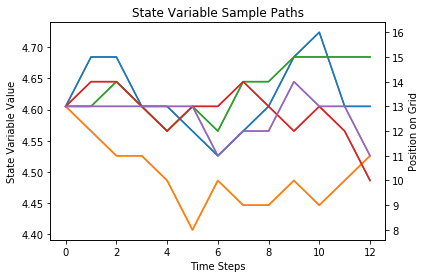

In [9]:
# plot 5 paths
plt.plot(X.T.iloc[:,[100,200,300,400,500]])
plt.xlabel('Time Steps')
plt.ylabel('State Variable Value')
plt.twinx()
plt.plot(point.T.iloc[:,[100,200,300,400,500]])
plt.xlabel('Time Steps')
plt.ylabel('Position on Grid')
plt.title('State Variable Sample Paths')
plt.show()

Based on simulated state variable $X_t$ paths, compute stock price $S_t$ by the following relation.

$$S_t=e^{X_t+\left(\mu-\frac{\sigma^2}{2}\right)t\Delta t}$$

$$\Delta S_t=S_{t+1}-e^{r\Delta t}S_t\quad t=0,...,T-1$$

$$\Delta\hat{S}_t=\Delta S_t-\Delta\bar{S}_t$$

where $\Delta\bar{S}_t$ is the sample mean of all values of $\Delta S_t$.

Plot of 5 stock price $S_t$ paths is shown below.

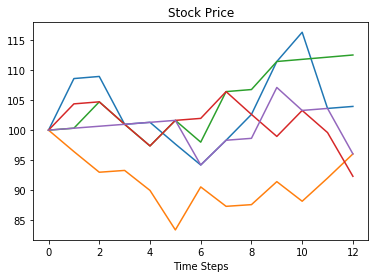

In [10]:
# stock price
S = X.apply(lambda x: np.exp((x + (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t).astype('float')), axis=1)
delta_S = S.loc[:, 1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

# plot 5 paths
plt.plot(S.T.iloc[:,[100,200,300,400,500]])
plt.xlabel('Time Steps')
plt.title('Stock Price')
plt.show()

### Setting Up the Market Impact Problem

We assume $N=10$ number of blocks, $M = 12$ possible stock prices, and $T=10$ time steps. All combinations of state and time can then be represented as a three-dimensional grid of size $N\times M\times T = 10\times 12\times 10$. A time-dependent action-value function $ Q_t(s_t, a_t)$ with four possible actions $ a_t = \left\{ a_{0}, a_{1}, a_{2}, a_{3}\right\} $ can then be stored as a rank-four tensor of dimension $ 10 \times 12 \times 10 \times 4 $. 

#### Setting some global parameters

In [11]:
BLOCK_SIZE = 1000
NUM_BLOCKS = 10
NUM_S      = 12  #number of discrete values of S
NUM_TIME_STEPS = 10
dt         = 1 # time step
sigma      = 0.1 # volatility
nu         = 1 # market friction parameter
S0         = 1 # initial stock price
lmbda      = 0.01 # risk aversion parameter

In [41]:
EPSILON = 0.1# Probability for exploration

ALPHA = 0.5# Step size

GAMMA = 1 # Discount factor for Q-Learning and Sarsa

We define the list of possible actions. $\left\{ a_{0}, a_{1}, a_{2}, a_{3}\right\} $ The integer value matches the subscript and represents the number of stocks to sell in that time-step.

In [13]:
ACTIONS = [0, 1, 2, 3]

We define the state vector for the initial state: the maximum number of stocks, the initial price $S_0$, and time $t = 0$

In [14]:
START = [NUM_BLOCKS - 1, S0, 0]

Step function that describes how the next state is obtained from the current state and the action taken. The function returns the next state and the reward obtained.

In [15]:
def step(state, action):
    X, S, t = state
    
    # You can't sell more stock than you have
    if action > X: 
        action = X
    
    # Calculate the number of stocks remaining
    X_next = X - action
    
    # Calculate the resulting price movement
    S_next = S*np.exp(1 - nu*action) + sigma*S*np.sqrt(dt)*np.random.randn() 
    # Quantise S_next to an allowed value
    S_next = np.clip(np.ceil(S_next), 0, NUM_S-1))
    
    next_state = [X_next, np.int(S_next), t+dt]
    
    # Calculate the reward earned from the sale
    mu = (np.exp(1 - nu * action) - 1) / dt
    var = S_next**2*np.exp(2*mu*dt + sigma**2*dt)*(np.exp(sigma**2*dt)-1)
    
    reward = BLOCK_SIZE * action*S - lmbda*BLOCK_SIZE * X_next**2*var
    
    return next_state, reward

In [16]:
# Check some state, action pairs and the associated reward
print(step(START, 0))
print(step([1,30,2], 0))

([9, 3, 1], -2299.981739633371)
([1, 11, 3], -381.7527990337968)


### Set up the agent's action policy

Given $S_t$ and $Q_t\left( s_t, a_t\right)$, this function chooses an action based on the epsilon-greedy algorithm

In [17]:
# Choose an action based on epsilon greedy algorithm
def choose_action(state, q_value, eps=EPSILON):
    # With probability `eps', simply choose a random action - 'Exploration'
    if np.random.binomial(1, eps) == 1:
        action = np.random.choice(ACTIONS)
    # Otherwise, choose from the actions with the highest
    # q-value for the given state - 'Exploitation'
    else:
        values_ = q_value[state[0], state[1], state[2], :]
        action = np.random.choice(
            [action_ for action_, value_ in enumerate(values_) 
                                 if value_ == np.max(values_)])
    # You cannot sell more stocks than you have
    if action > state[0]:
        action = state[0]
    
    return action

For example, when `q_value` is all zeroes, the action taken is always random:

In [18]:
q_value = np.zeros((NUM_BLOCKS, NUM_S, NUM_TIME_STEPS, len(ACTIONS)))
[choose_action(START, q_value, EPSILON) for i in range(20)]

[1, 3, 1, 3, 1, 3, 3, 0, 2, 2, 3, 2, 0, 0, 0, 1, 2, 2, 0, 0]

### Set up the learning algorithms

#### Sarsa and Expected Sarsa

This function simulates an episode with Sarsa. It takes the state-action value array `q_value` as an argument, initialises the state to `START`, defined above, and updates `q_value` according to the Sarsa algorithm, until the $T$ time steps have passed, or the stocks have all been sold. The cumulative reward earned is returned.

In [49]:
def sarsa(q_value, expected=False, step_size=ALPHA, eps=EPSILON):
    state = START
    action = choose_action(state, q_value,eps)
    rewards = 0.0
    while (state[2] < (NUM_TIME_STEPS-1)*dt) and (state[0] > 0):
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, q_value, eps)
        rewards += reward
        if not expected:
            target = q_value[next_state[0], next_state[1], next_state[2], next_action]
        else:
            # Calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], next_state[2], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - eps) / len(best_actions) 
                               + eps / len(ACTIONS)) * q_value[next_state[0], next_state[1], next_state[2], action_]
                else:
                    target += eps / len(ACTIONS) * q_value[next_state[0], next_state[1], next_state[2], action_]
        target *= GAMMA
        q_value[state[0], state[1], state[2], action] += step_size * (
                reward + target - q_value[state[0], state[1], state[2], action])
        state = next_state
        action = next_action
    return rewards

#### Q-learning

This function simulates an episode with Q-learning. It takes the state-action value array `q_value` as an argument, initialises the state to `START`, defined above, and updates `q_value` according to the Q-learning algorithm, until the $T$ time steps have passed, or the stocks have all been sold. The cumulative reward earned is returned.

In [20]:
def q_learning(q_value, step_size=ALPHA, eps=EPSILON):
    state = START
    rewards = 0.0
    
    while (state[2] < (NUM_TIME_STEPS-1)*dt) and (state[0] > 0):
        action = choose_action(state, q_value, eps)
        next_state, reward = step(state, action)
        rewards += reward
        # Q-Learning update
        Qhere = q_value[state[0], state[1], state[2], action]
        
        bestQnext = max(q_value[next_state[0], next_state[1], next_state[2], :])
        
        nextQhere = Qhere + step_size*(reward + GAMMA*bestQnext - Qhere)
        
        q_value[state[0], state[1], state[2], action] += step_size * (reward 
            + GAMMA * np.max(q_value[next_state[0], next_state[1], next_state[2], :]) 
            - q_value[state[0], state[1], state[2], action])
        
        if nextQhere !=  q_value[state[0], state[1], state[2], action]:
            print()
        
        state = next_state
    return rewards

### Running Sarsa and Q-learning to compare their asymptotic behaviour

This function will plot the average (over `runs` independent trials) rewards earned by SARSA and Q-learning after each iteration (up to `episodes`).

In [52]:
def figure_9_4(episodes=1000, runs=100):
    EPOCH=25
    
    # Initialise the rewards arrays
    rewards_sarsa = np.zeros(episodes)
    rewards_q_learning = np.zeros(episodes)
    
    for r in tqdm(range(runs)):
        # Initialise the state-action arrays 
        q_sarsa = np.zeros((NUM_BLOCKS, NUM_S, NUM_TIME_STEPS, len(ACTIONS)))
        q_q_learning = np.copy(q_sarsa)
        # Update the rewards and action value arrays for each episode
        for i in range(0, episodes):
            # The value of epsilon is decremented exponentially
            # after every EPOCH episodes
            eps = EPSILON*((1-EPSILON)**(i//EPOCH))
            rewards_sarsa[i] += sarsa(q_sarsa, eps=eps)
            rewards_q_learning[i] += q_learning(q_q_learning, eps=eps)
    
    # Averaging over independent runs
    rewards_sarsa /= runs
    rewards_q_learning /= runs
    
    # Draw reward curves
    plt.plot(rewards_sarsa, label='Sarsa')
    plt.plot(rewards_q_learning, label='Q-Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.legend()

    return q_sarsa, q_q_learning

100%|██████████| 50/50 [06:57<00:00,  8.35s/it]


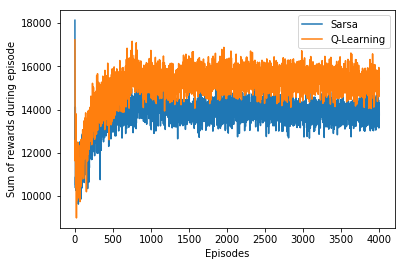

In [55]:
q_sarsa, q_q_learning = figure_9_4(1200, 50)

Display the resulting optimal policies

In [23]:
def print_optimal_policy(q_value):
    optimal_policy = np.zeros((NUM_BLOCKS, NUM_S, NUM_TIME_STEPS))
    for i in range(0, NUM_BLOCKS):
        for j in range(0, NUM_S):
            for k in range(0, NUM_TIME_STEPS):
                optimal_policy[i,j,k] = np.argmax(q_value[i, j, k, :])
    for k in range(0, NUM_TIME_STEPS):
      print("========= time step " + str(k) + "======") 
      print(" price: 1,2,3,4,5,6,7,8,9,10,11,12")
      for i in range(0, NUM_BLOCKS):
        str_="inventory " + str(i) + ":"    
        for j in range(0, NUM_S): 
            str_+=str(np.int(optimal_policy[i,j,k])) + ','
        print(str_)    

In [24]:
print('Sarsa Optimal Policy:')
print_optimal_policy(q_sarsa)
print('Q-Learning Optimal Policy:')
print_optimal_policy(q_q_learning)

Sarsa Optimal Policy:
========= time step 0======
 price: 1,2,3,4,5,6,7,8,9,10,11,12
inventory 0:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 1:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 2:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 3:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 4:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 5:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 6:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 7:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 8:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 9:0,2,0,0,0,0,0,0,0,0,0,0,
========= time step 1======
 price: 1,2,3,4,5,6,7,8,9,10,11,12
inventory 0:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 1:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 2:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 3:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 4:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 5:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 6:0,2,0,0,0,0,0,0,0,0,0,0,
inventory 7:0,3,0,0,0,0,0,0,0,0,0,0,
inventory 8:0,1,2,0,0,0,0,0,0,0,0,0,
inventory 9:0,0,0,2,0,0,0,0,0,0,0,0,
========= time step 2======
 price: 1,2,3,4,5,6,7,8,9,10,11,12
inventory 0:0,0,0,0,0,0,0,0,0,0,0,0,
inventory 1: